In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib import animation
from mpl_toolkits.mplot3d import axes3d
import argparse
from scipy.optimize import minimize 
from matplotlib import cm
from IPython.display import HTML
import matplotlib as mpl

In [54]:
def animate(fig,idx,im1,im2,pos,trpos,trmu):
    im2._offsets3d = (trpos[idx][0], trpos[idx][1], trpos[idx][2])
    im2.set_sizes(trmu[idx]) 

    plt.gca().relim()
    plt.gca().autoscale_view()
    fig.suptitle('snapshot:{:d}, #collisions:{:d}'.format(idx,len(pos[idx,0,:])-len(trpos[idx][0])))
    #return (im1,im2) 

def prepare_animation(bar_containers, vels, imms, axh, Mu):

    def animate(frame_number, vels, imms, axh, Mu):
        legnd = []
        max_count = -1e34
        min_max_count = 1e34
        for idx,vel in enumerate(vels[frame_number]):
            if len(vel)>1:
                n, _ = np.histogram(vel, bins=30, density=True)
                for count, rect in zip(n, bar_containers[idx].patches):
                    rect.set_height(count)
                    max_count = np.max((count, max_count)) 
                min_max_count = np.min((min_max_count, max_count))
                sigma2 = (vel**2).sum()/(3*len(vel))
                vl = np.linspace(0, np.max(vel)*1.3, 200)
                imms[idx].set_data(vl , 4*np.pi*vl**2/np.power(np.pi*2*sigma2, 3.0/2) * np.exp(-vl**2/2/sigma2))
                axh.set(title=r'$N(\sigma|v) = \frac{{4\pi v^2}}{{(\pi 2 \sigma)^{{3/2}} }} e^{{\frac{{-v^2}}{{2\sigma}} }}$')
                legnd.append(r'$\sigma_{{\mu_p={:.0f}}}={:.3f}$'.format(Mu[frame_number][idx],sigma2))
            else:
                for rect in bar_containers[idx].patches:
                    rect.set_height(0)
                imms[idx].set_data([0,0],[0,0])
        axh.legend(legnd)
        axh.set_ylim(top=min_max_count*2.3)
        if idx<len(bar_containers)-1:
            for i in range(idx, len(bar_containers)):
                for rect in bar_containers[i].patches:
                    rect.set_height(0)
                imms[i].set_data([0,0],[0,0])
        #return bar_container.patches
        return [container.patches for container in bar_containers]
    return lambda frame_number : animate(frame_number, vels, imms, axh, Mu)

In [55]:
numframes = 450
outfile = ''
scl = 1
indir = 'output/mu10_b1_kTG100_bx1000_n8000//'

<IPython.core.display.Javascript object>


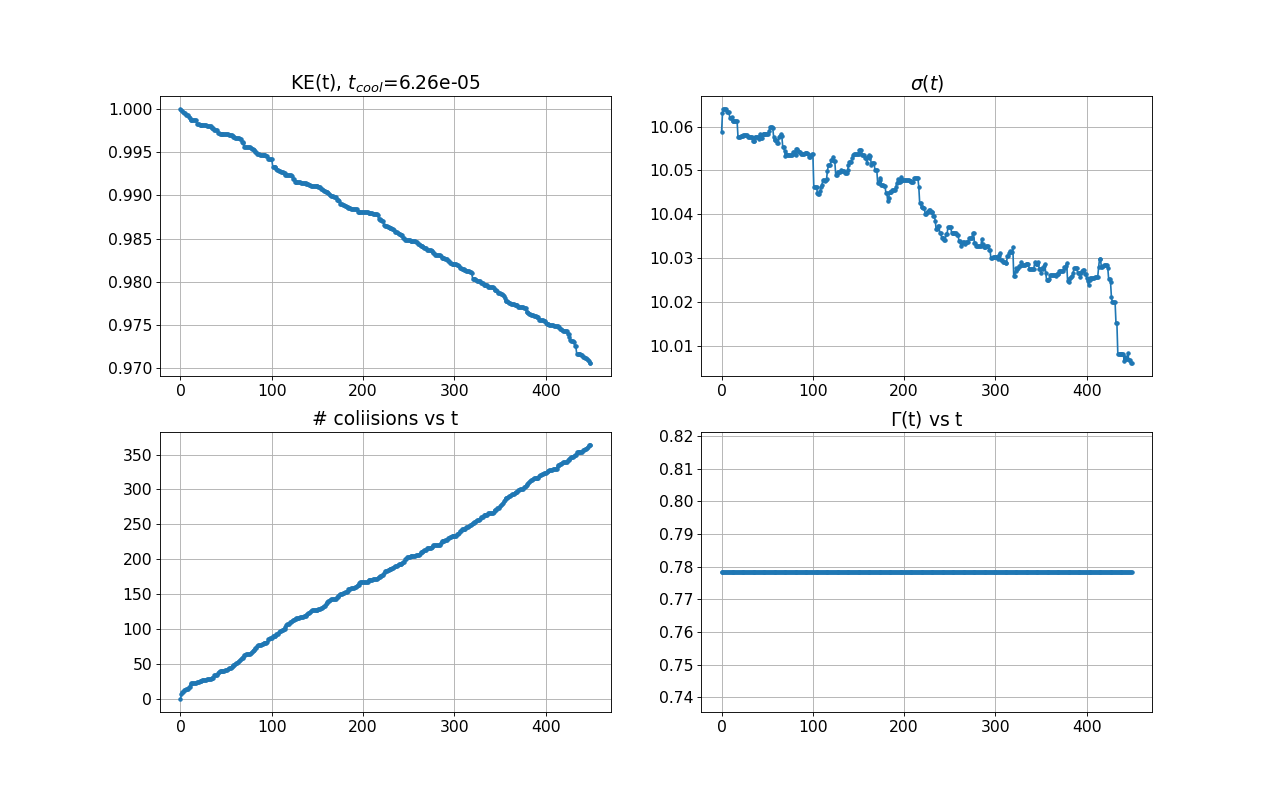

[Text(0.5, 1.0, '$\\Gamma$(t) vs t')]

In [56]:
plt.rcParams.update({"font.size":14})
pos = []
vel = []
trpos = []
trvel = []
trmu = []
n_collisions = [] 
for i in range(1,numframes+1):
    h5file = h5py.File(indir+"test_grav_"+str(i)+".hdf5")
    pos.append(h5file["particles/pos"][:,:])
    vel.append(h5file["particles/vel"][:,:])
    trpos.append(h5file["tracers/pos"][:,:])
    trvel.append(h5file["tracers/vel"][:,:])
    trmu.append(h5file["tracers/mu"][:])
    n_collisions.append(len(pos[-1][0])-len(trpos[-1][0]))


pos = np.array(pos)
vel = np.array(vel)
n_collisions = np.array(n_collisions)
coefs = np.polyfit(np.arange(len(n_collisions)-1), n_collisions[1:], 1)
Gamma = coefs[0]*np.ones_like(n_collisions)

E = []
sigs = []
Sig = []
v = []
Mu = []
for i,tv in enumerate(trvel): #tv is 3 x N_particles
    v2 = (tv**2).sum(axis=0)
    E.append((0.5*trmu[i]*v2).sum())
    sigs.append(tv.var(axis=1))
    Sig.append(v2.sum()/(3*len(v2)))
    v_ = []
    Mu_ = []
    for mu in np.unique(trmu[i]):
        mask = trmu[i] == mu
        tv_ = np.array(tv[:,mask])
        v2_ = (tv_**2).sum(axis=0)
        v_.append(np.sqrt(v2_))
        Mu_.append(mu)
    v.append(v_)
    Mu.append(Mu_)

E = np.array(E)
sigs=np.array(sigs) 

#dEdt = np.diff(E)/np.diff(np.ones(len(E)))
fig_E, ax_E = plt.subplots(2,2,figsize=(16,10))
ax_E[0,0].plot(E/E.max(),'.-')
ax_E[0,0].grid()
ax_E[0,0].set(title='KE(t), $t_{{cool}}$={:.2e}'.format(np.abs(np.polyfit(np.arange(len(E)-1),E[1:],1)[0])/np.mean(E)))
ax_E[0,1].plot(Sig,'.-')
#ax_E[1].plot(sigs, '.-')
ax_E[0,1].grid()
ax_E[0,1].set(title = r'$\sigma(t)$')
#ax_E[0,1].legend((r'$\sigma^2$', r'$\sigma_x^2$',r'$\sigma_y^2$',r'$\sigma_z^2$'))

ax_E[1,0].plot(n_collisions,'.-')
ax_E[1,0].grid()
ax_E[1,0].set(title='# coliisions vs t')
ax_E[1,1].plot(Gamma, '.-')
ax_E[1,1].grid()
ax_E[1,1].set(title=r'$\Gamma$(t) vs t')

<IPython.core.display.Javascript object>


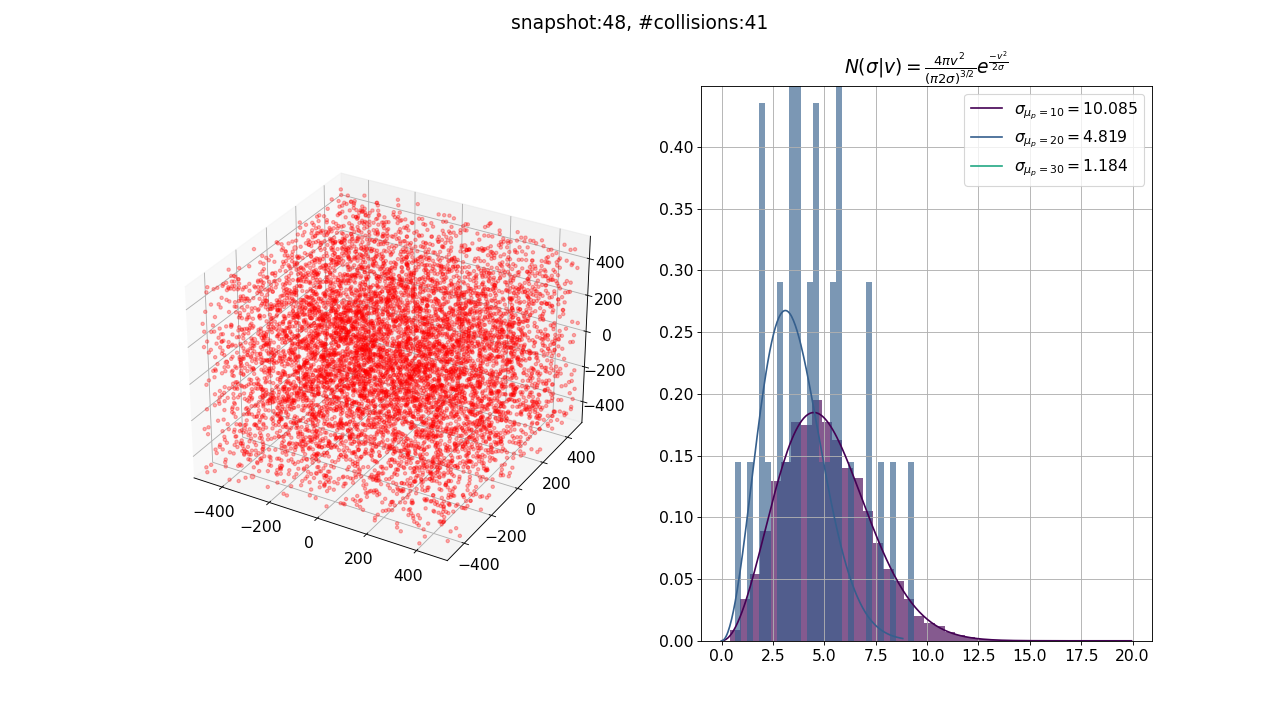

In [57]:
%matplotlib notebook
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(121,projection='3d')
ani = animation.FuncAnimation(fig, lambda idx : animate(fig,idx,im1,im2,pos,trpos,trmu), blit=False, interval=25, frames=numframes, repeat_delay=300)

im1 = []# ax.scatter(pos[0,0,:], pos[0,1,:], pos[0,2,:], marker='*')#,s=8)
im2 = ax.scatter(trpos[0][0], trpos[0][1], trpos[0][2], marker='8', color='r', alpha=0.3)#, s=8*np.ones_like(trpos[0][0]))

ax.set_xlim([pos.min()/scl, pos.max()/scl])
ax.set_ylim([pos.min()/scl, pos.max()/scl])
ax.set_zlim([pos.min()/scl, pos.max()/scl])
ax.grid()

axh = fig.add_subplot(122)
bx_list = []
im_list = []
cmap = cm.get_cmap('viridis')
clr_list = cmap(np.linspace(0,0.9,len(v[-1])))
for i, v_ in enumerate(v[-1]): #get the full number of histogram plots you could need 
    _,_,box_container = axh.hist(v_, density=True, bins=30, color=clr_list[i], alpha=0.65)
    bx_list.append(box_container)
    #res = minimize(lambda s2,ve : (ve**2).sum()/2/s2 + len(ve)*3/2*np.log(np.pi*2*s2), x0=4, args=(v[0]) )
    sigma2 = (v_**2).sum()/(3*len(v_))
    vl = np.linspace(0,np.max(v_),100)
    imm, = axh.plot(vl, 4*np.pi*vl**2/np.power(np.pi*2*sigma2, 3.0/2) * np.exp(-vl**2/2/sigma2), c=clr_list[i])
    im_list.append(imm)

#axh.hist(v0, density=True, bins=30)
#res = minimize(lambda s2,ve : (ve**2).sum()/2/s2 + len(ve)*3/2*np.log(np.pi*2*s2), x0=4, args=(v[0]) )
#sigma2 = (v[0]**2).sum()/(3*len(v[0]))
#vl = np.linspace(0,np.max(v[0]),100)
#imm, = axh.plot(vl, 4*np.pi*vl**2/np.power(np.pi*2*sigma2, 3.0/2) * np.exp(-vl**2/2/sigma2), 'b-')

axh.set_ylim(top=2)#axh.get_ylim()[1]*1.3)
axh.grid()

ani2 = animation.FuncAnimation(fig, prepare_animation(bx_list, v, im_list, axh, Mu), blit=False, interval=25, frames=numframes, repeat_delay=300) 

if len(outfile)>0:
    writermp4 = animation.FFMpegWriter(bitrate=600, fps=10)
    ani.save(outfile+'.mp4', writer=writermp4)

#HTML(ani.to_jshtml())
#HTML(ani2.to_jshtml())

plt.show()

[Text(0.5, 1.0, '$\\Gamma\\;\\; vs \\;\\; n_{particles}$'), None]

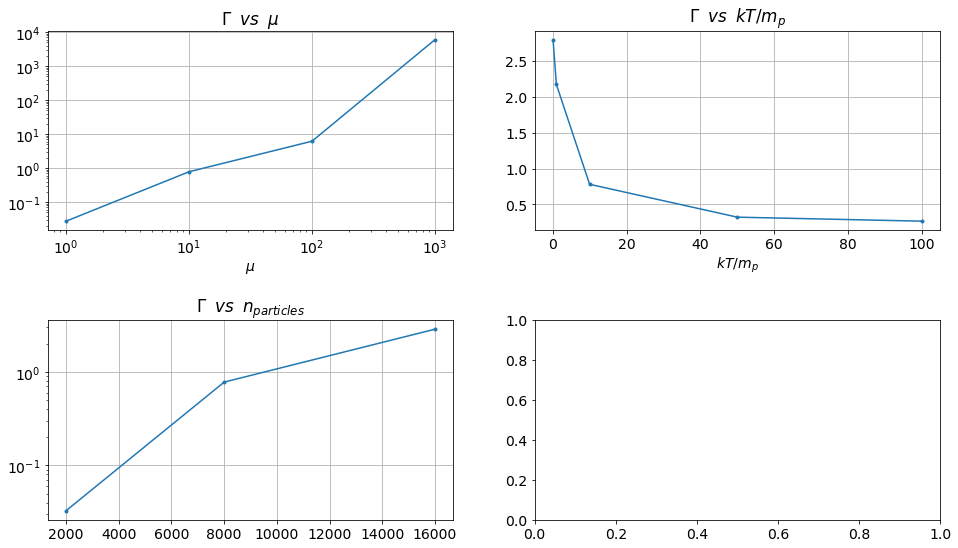

In [41]:
mu = [1,10,100,1000]
gamma_mu = [0.0275,0.78,6.18,6000]
kTG = np.array([1,10,100,500,1000]) / 10
gamma_kTG = [2.80,2.175,0.78,0.321,0.265]
n_particles = [2000,8000,16000]
gamma_np = [0.03275,0.78,2.875]
fig, ax = plt.subplots(2,2,figsize=(16,9),gridspec_kw={'hspace':0.45})
ax[0,0].plot(mu, gamma_mu,'.-')
ax[0,0].grid()
ax[0,0].set(title=r'$\Gamma\;\; vs \;\; \mu$',xscale='log', yscale='log', xlabel=r'$\mu$')

ax[0,1].plot(kTG, gamma_kTG,'.-')
ax[0,1].grid()
ax[0,1].set(title=r'$\Gamma\;\; vs \;\; kT/m_p$',xlabel=r'$kT/m_p$')

ax[1,0].plot(n_particles, gamma_np,'.-')
ax[1,0].grid()
ax[1,0].set(title=r'$\Gamma\;\; vs \;\; n_{particles}$', yscale='log')

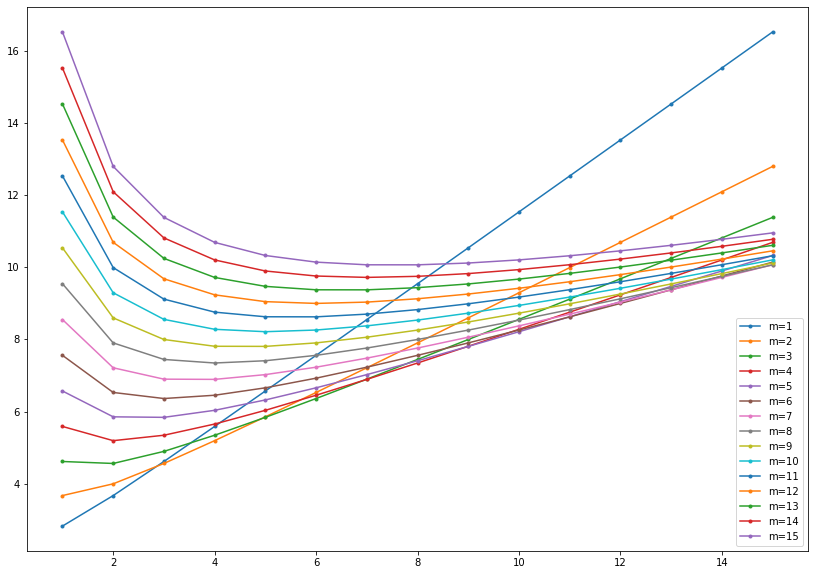

In [25]:
fig, ax = plt.subplots(1,figsize=(14,10))
m1 = np.linspace(1,15,15,dtype=int)
for m in m1:
    ax.plot(m1, np.sqrt((m1+m)**3 / (m1*m)), '.-', label='m={:d}'.format(m))
ax.legend()
plt.show()